In [1]:
import numpy as np
import pandas as pd
from graph_tool.all import *
import cairo
import configparser
config = configparser.ConfigParser()
a = config.read('config.ini')

In [2]:
%run delay.ipynb

In [3]:
# class of node
class AbstractNode:
    def __init__(self, name, show_name, vertex, nid):
        self.name = name
        self.show_name = show_name
        self.vertex = vertex
        self.nid = nid
        self.x = 0.0
        self.y = 0.0
        self.links = []
    
    def append_link(self,link):
        self.links.append(link)
        
        
class Node(AbstractNode):
    def __init__(self, nid, name, show_name, vertex, node_type, surface_url):
        super().__init__(name, show_name, vertex,nid)
        self.links = []
        self.type = node_type  
        self.surface_url = surface_url
        self.total_delay = 0.0
        
        
    def get_total_delay_format(self):
        return f"{self.total_delay:.2e}"
    
#     def set_link(target,)
class Label(AbstractNode):
    def __init__(self, name, show_name, vertex,main_node,x_off,y_off):
        super().__init__(name, show_name, vertex, main_node.x+float(x_off), main_node.y+float(y_off))


In [4]:
# class of edge
class AbstractEdge:
    def __init__(self, start_node, end_node, edge):
        self.start_node = start_node
        self.end_node = end_node
        self.edge = edge

class Link(AbstractEdge):
    def __init__(self, start_node, end_node, trans_bandwidth, prop_distance, dash, edge,loss_up,loss_down):
        super().__init__(start_node, end_node, edge)
        self.trans_bandwidth = trans_bandwidth
        self.prop_distance = prop_distance
        self.dash = dash
        self.loss_up = loss_up
        self.loss_down = loss_down
        self.delay_up = 0.0
        self.delay_down = 0.0
        
    def get_destance_format(self):
        return f'{float(self.prop_distance):.2f}Km'
        
    def get_band_format(self):
        return f'{float(self.trans_bandwidth):.0f}MB'
    
    def get_self_delay(self,transPackageSize):
        self.delay_up = networkMessageDelay(transPackageSize=transPackageSize,
                                         transBandWidth=self.trans_bandwidth,
                                         propagationDistance=self.prop_distance,
                                         propagationLoss=self.loss_up)
        self.delay_down = networkMessageDelay(transPackageSize=transPackageSize,
                                         transBandWidth=self.trans_bandwidth,
                                         propagationDistance=self.prop_distance,
                                         propagationLoss=self.loss_down)
#         print(self.delay_up)
#         print(self.delay_down)
class Route(AbstractEdge):
    def __init__(self, start_node, end_node, edge):
        super().__init__(start_node, end_node, edge)
        
#     def get_delay_format(self):
#         return f'Delay:{self.delay:.2e}ms'

In [5]:
# functions
def find_node_by_name(nodes,name):
    for node in nodes:
        if node.name == name:
            return node
    return None

def find_node_by_id(nodes,nid):
    for node in nodes:
        if node.nid == nid:
            return node
    return None

def is_linked(links,start_node,end_node):
    for link in links:
        if (link.start_node == start_node and link.end_node == end_node) or (link.start_node == end_node and link.end_node == start_node):
            return True
    return False

def find_link_by_nodes_name(links,name1,name2):
    for link in links:
        if (link.start_node.name, link.end_node.name) in [(name1, name2), (name2, name1)]:
            return link
    return None

def find_link_by_nodes(links,node1,node2):
    for link in links:
        if (link.start_node, link.end_node) in [(node1, node2), (node2, node1)]:
            return link
    return None

def find_node_by_vertex(nodes,vertex):
    for node in nodes:
        if node.vertex == vertex:
            return node
    return None

def add_new_link(nodes,start_node, end_node, trans_bandwidth, prop_distance, dash):
    if (start_node is None) or (end_node is None):
        return
    new_edge = g.add_edge(start_node.vertex,end_node.vertex)
    new_link = Link(start_node=start_node
                    ,end_node=end_node
                    ,trans_bandwidth=trans_bandwidth
                    ,prop_distance=prop_distance
                    ,dash=dash
                    ,edge=new_edge
                    )
    return new_link

def get_distance_auto(device1, device2):
    if device1 == "Clock" and device2 == "WifiRouter":
        return np.round(np.random.uniform(0.1, 1.0), 2)
    if device1 == "WifiRouter" and device2 == "MainRouter":
        return np.round(np.random.uniform(0.1, 1.0), 2)
    elif device1 == "MainRouter" and device2 == "MainRouter":
        return np.round(np.random.uniform(1, 1000), 2)
    else:
        return np.round(np.random.uniform(1, 10), 2)

def get_bandwidth_auto(device1, device2):
    if device1 == "Clock" and device2 == "WifiRouter":
        return np.random.choice(np.arange(128, 1025, 128))*1.0
    if device1 == "WifiRouter" and device2 == "MainRouter":
        return np.random.choice(np.arange(128, 1025, 128))*1.0
    elif device1 == "MainRouter" and device2 == "MainRouter":
        return np.random.choice(np.arange(1024, 10241, 128))*1.0
    else:
        return np.round(np.random.uniform(1, 10), 2)
    
def get_lost_auto(device1, device2):
    if device1 == "Clock" and device2 == "WifiRouter":
        return np.round(np.random.uniform(0.1, 0.2), 2)
    if device1 == "WifiRouter" and device2 == "MainRouter":
        return np.round(np.random.uniform(0.1, 0.2), 2)
    elif device1 == "MainRouter" and device2 == "MainRouter":
        return np.round(np.random.uniform(0.05, 0.1), 2)
    else:
        return np.round(np.random.uniform(1, 10), 2)

def add_new_link_auto(start_node, end_node, dash):
    if (start_node is None) or (end_node is None):
        return
    new_edge = g.add_edge(start_node.vertex,end_node.vertex)
    new_link = Link(start_node=start_node
                    ,end_node=end_node
                    ,trans_bandwidth=get_bandwidth_auto(start_node.type,end_node.type)
                    ,prop_distance=get_distance_auto(start_node.type,end_node.type)
                    ,dash=dash
                    ,edge=new_edge
                    ,loss_up=get_lost_auto(start_node.type,end_node.type)
                    ,loss_down=get_lost_auto(start_node.type,end_node.type)
                    )
    start_node.append_link(new_link)
    end_node.append_link(new_link)
    return new_link

def add_new_route(start_node, end_node):
    if (start_node is None) or (end_node is None):
        return
    new_edge = g.add_edge(start_node.vertex,end_node.vertex)
    new_link = Route(start_node=start_node
                    ,end_node=end_node
                    ,edge=new_edge)
    return new_link

def find_type_in_neighbor(node,target_type):
    res = 0
    for link in node.links:
        if(node != link.start_node):
            if(link.start_node.type == target_type):
                res+=1
        if(node != link.end_node):
            if(link.end_node.type == target_type):
                res+=1   
    return res

def get_delay_format(delay):
    return f'Delay:{delay:.2e}ms'

In [6]:
# basic var
# if this part changed, all cell below need restart 
nodes = []
links = []
routes = []
scene_path = config.get('config', 'scene_path')+"sim_auto/"
package_size = float(config.get('config', 'package_size'))
g = Graph(directed=False)
g_sfcs = g.new_vertex_property("object")
g_pos = g.new_vertex_property("vector<float>")
g_shape = g.new_vertex_property("string")
g_eorder = g.new_edge_property("int")

g_v_label = g.new_vertex_property("string")
g_v_size = g.new_vertex_property("double")
g_v_color = g.new_vertex_property("string")
g_v_fill_color = g.new_vertex_property("string")
g_v_pen_width = g.new_vertex_property("float")
g_v_halo = g.new_vertex_property("bool")
g_v_text_position = g.new_vertex_property("float")
g_v_text_offset = g.new_vertex_property("vector<int>")
g_v_font_size = g.new_vertex_property("int")
g_v_halo_color = g.new_vertex_property("string")
g_v_halo_size = g.new_vertex_property("float")

g_e_end_mark = g.new_edge_property("string")
g_e_start_mark = g.new_edge_property("string")
g_e_pen_width = g.new_edge_property("int")
g_e_marker_size = g.new_edge_property("int")
g_e_text = g.new_edge_property("string")
g_e_text_parallel = g.new_edge_property("bool")
g_e_text_font_size = g.new_edge_property("int")
g_e_color = g.new_edge_property("string")
g_e_text_distance = g.new_edge_property("float")
g_e_dash_style = g.new_edge_property("vector<float>")

In [7]:
# create nodes
# data = np.genfromtxt(scene+'nodes.csv', delimiter=',', dtype=str,encoding='utf-8-sig')
nodes_df = pd.read_csv(scene_path+'nodes.csv')
for i in range(len(nodes_df)):
    new_node = Node(nid=nodes_df.iloc[i]["id"]
                          ,name=nodes_df.iloc[i]["name"]
                          ,show_name=nodes_df.iloc[i]["show_name"]
                          ,vertex=g.add_vertex()
                          ,node_type=nodes_df.iloc[i]["type"]
                          ,surface_url=nodes_df.iloc[i]["surface"]
                         )
    nodes.append(new_node)
    n_v = new_node.vertex
    if(len(new_node.surface_url)):
        g_sfcs[n_v] = cairo.ImageSurface.create_from_png(config.get('config', 'resource_path')+new_node.surface_url)
    g_v_label[n_v] = new_node.show_name
    g_v_color[n_v] = "w"
    g_v_fill_color[n_v] = "w"
    g_v_pen_width[n_v] = 0.0
    g_v_text_position[n_v] = -0.5
    g_v_text_offset[n_v] = [0,0]
    g_v_font_size[n_v] = 20
    g_v_size[n_v] = 50
    


In [8]:
# create links
deL_num = 0
# random.shuffle(nodes)
group_clock = 20
group_router = 0
g_v_group = g.new_vertex_property("int")
g_e_up_delay = g.new_edge_property("float")
g_e_down_delay = g.new_edge_property("float")
for i in range(len(nodes)):
    for j in range(len(nodes)):
        if(i == j):
            continue
        n1 = nodes[i]
        n2 = nodes[j]
        if(is_linked(links,n1,n2)):
            continue
        if(n1.type == "Clock" and n2.type == "Clock"):
            continue
        if(n1.type == "WifiRouter" and n2.type == "WifiRouter"):
            continue
        if(n1.type == "Clock" and (len(n1.links)>0 or (n2.type != "WifiRouter" or find_type_in_neighbor(n2,"Clock")>0))):
            continue
        if(n2.type == "Clock" and (len(n2.links)>0 or (n2.type != "WifiRouter" or find_type_in_neighbor(n1,"Clock")>0))):
            continue
        if(n1.type == "WifiRouter" and n2.type == "MainRouter" and find_type_in_neighbor(n1,"MainRouter")>0):
            continue
        if(n2.type == "WifiRouter" and n1.type == "MainRouter" and find_type_in_neighbor(n2,"MainRouter")>0):
            continue
        if(n1.type == "MainRouter" and n2.type == "WifiRouter" and find_type_in_neighbor(n1,"WifiRouter")>0):
            continue
        if(n2.type == "MainRouter" and n1.type == "WifiRouter" and find_type_in_neighbor(n2,"WifiRouter")>0):
            continue
        if(n1.type == "MainRouter" and n2.type == "MainRouter"):
            if(find_type_in_neighbor(n1,"WifiRouter")>0 and find_type_in_neighbor(n2,"WifiRouter")>0):
                continue
            if(random.random() > 0.57):
                continue
        if(n1.type == "Clock" or n2.type == "Clock"):
            g_v_group[n1.vertex] = group_clock
            g_v_group[n2.vertex] = group_clock
            group_clock+=10
        if(n1.type == "MainRouter" and n2.type == "MainRouter"):
            g_v_group[n1.vertex] = group_router
            g_v_group[n2.vertex] = group_router
        new_link = add_new_link_auto(start_node=n1, end_node=n2, dash="0")
        new_link.get_self_delay(package_size)
        links.append(new_link)
        l_e = new_link.edge
        g_eorder[l_e] = 0
        g_e_up_delay[l_e] = new_link.delay_up
        g_e_down_delay[l_e] = new_link.delay_down
        g_e_color[l_e] = "black"
        g_e_text_parallel[l_e] = True
        g_e_text[l_e] = f'{new_link.get_destance_format()} {new_link.get_band_format()}'
        g_e_text_font_size[l_e] = 10
        g_e_end_mark[l_e] = "none"
        g_e_pen_width[l_e] = 1
        g_e_text_distance[l_e] = -10.0
        if new_link.dash == '1':
            g_e_dash_style[l_e] = [1, 1, 0]
        else:
            g_e_dash_style[l_e] = [10000, 100000, 0]

In [9]:
# add_auto_route
# upstream
start_node = None
end_node = None
total_delay = 0.0
if config.get('config', 'show_best_route') == "Y":
    clock_nodes = [node for node in nodes if node.type == 'Clock']
    route_nodes_list = []
    if(len(clock_nodes)>1):
        # upstream
        start_node, end_node = random.sample(clock_nodes, 2)
        dist, pred = dijkstra_search(g, g_e_up_delay, start_node.vertex)
        node = end_node
        while node != start_node:
            pre_node = find_node_by_vertex(nodes,g.vertex(pred[node.vertex]))
            route_nodes_list.append((pre_node,node,"up"))
            node = pre_node
        # downstream
        start_node,end_node = end_node,start_node
        dist, pred = dijkstra_search(g, g_e_down_delay, start_node.vertex)
        node = end_node
        while node != start_node:
            pre_node = find_node_by_vertex(nodes,g.vertex(pred[node.vertex]))
            route_nodes_list.append((pre_node,node,"down"))
            node = pre_node
    for node_pair in route_nodes_list:
        link = find_link_by_nodes(links,node_pair[0],node_pair[1])
        new_route = add_new_route(start_node=node_pair[1],end_node=node_pair[0])
        g_e_text_parallel[new_route.edge] = True
        g_e_end_mark[new_route.edge] = "arrow"
        g_e_pen_width[new_route.edge] = 2
        g_e_marker_size[new_route.edge] = 10
        if(node_pair[2]=="up"):
            g_e_color[new_route.edge] = "g"
            total_delay += link.delay_up
            g_eorder[new_route.edge] = 1
        else:
            g_e_color[new_route.edge] = "b"
            total_delay += link.delay_down
            g_eorder[new_route.edge] = 2
        g_e_text[new_route.edge] = get_delay_format(total_delay)
        g_e_text_font_size[new_route.edge] = 10
        g_e_text_distance[new_route.edge] = 10.0
        g_e_dash_style[new_route.edge] = [10, 10, 0]

In [10]:
g_pos = sfdp_layout(g,p=3.0,groups=g_v_group, gamma=3.0, K=400, mu=5,kappa=1.0)

Total Package Size = 1024.0Byte
Total Delay:2.64e-02ms


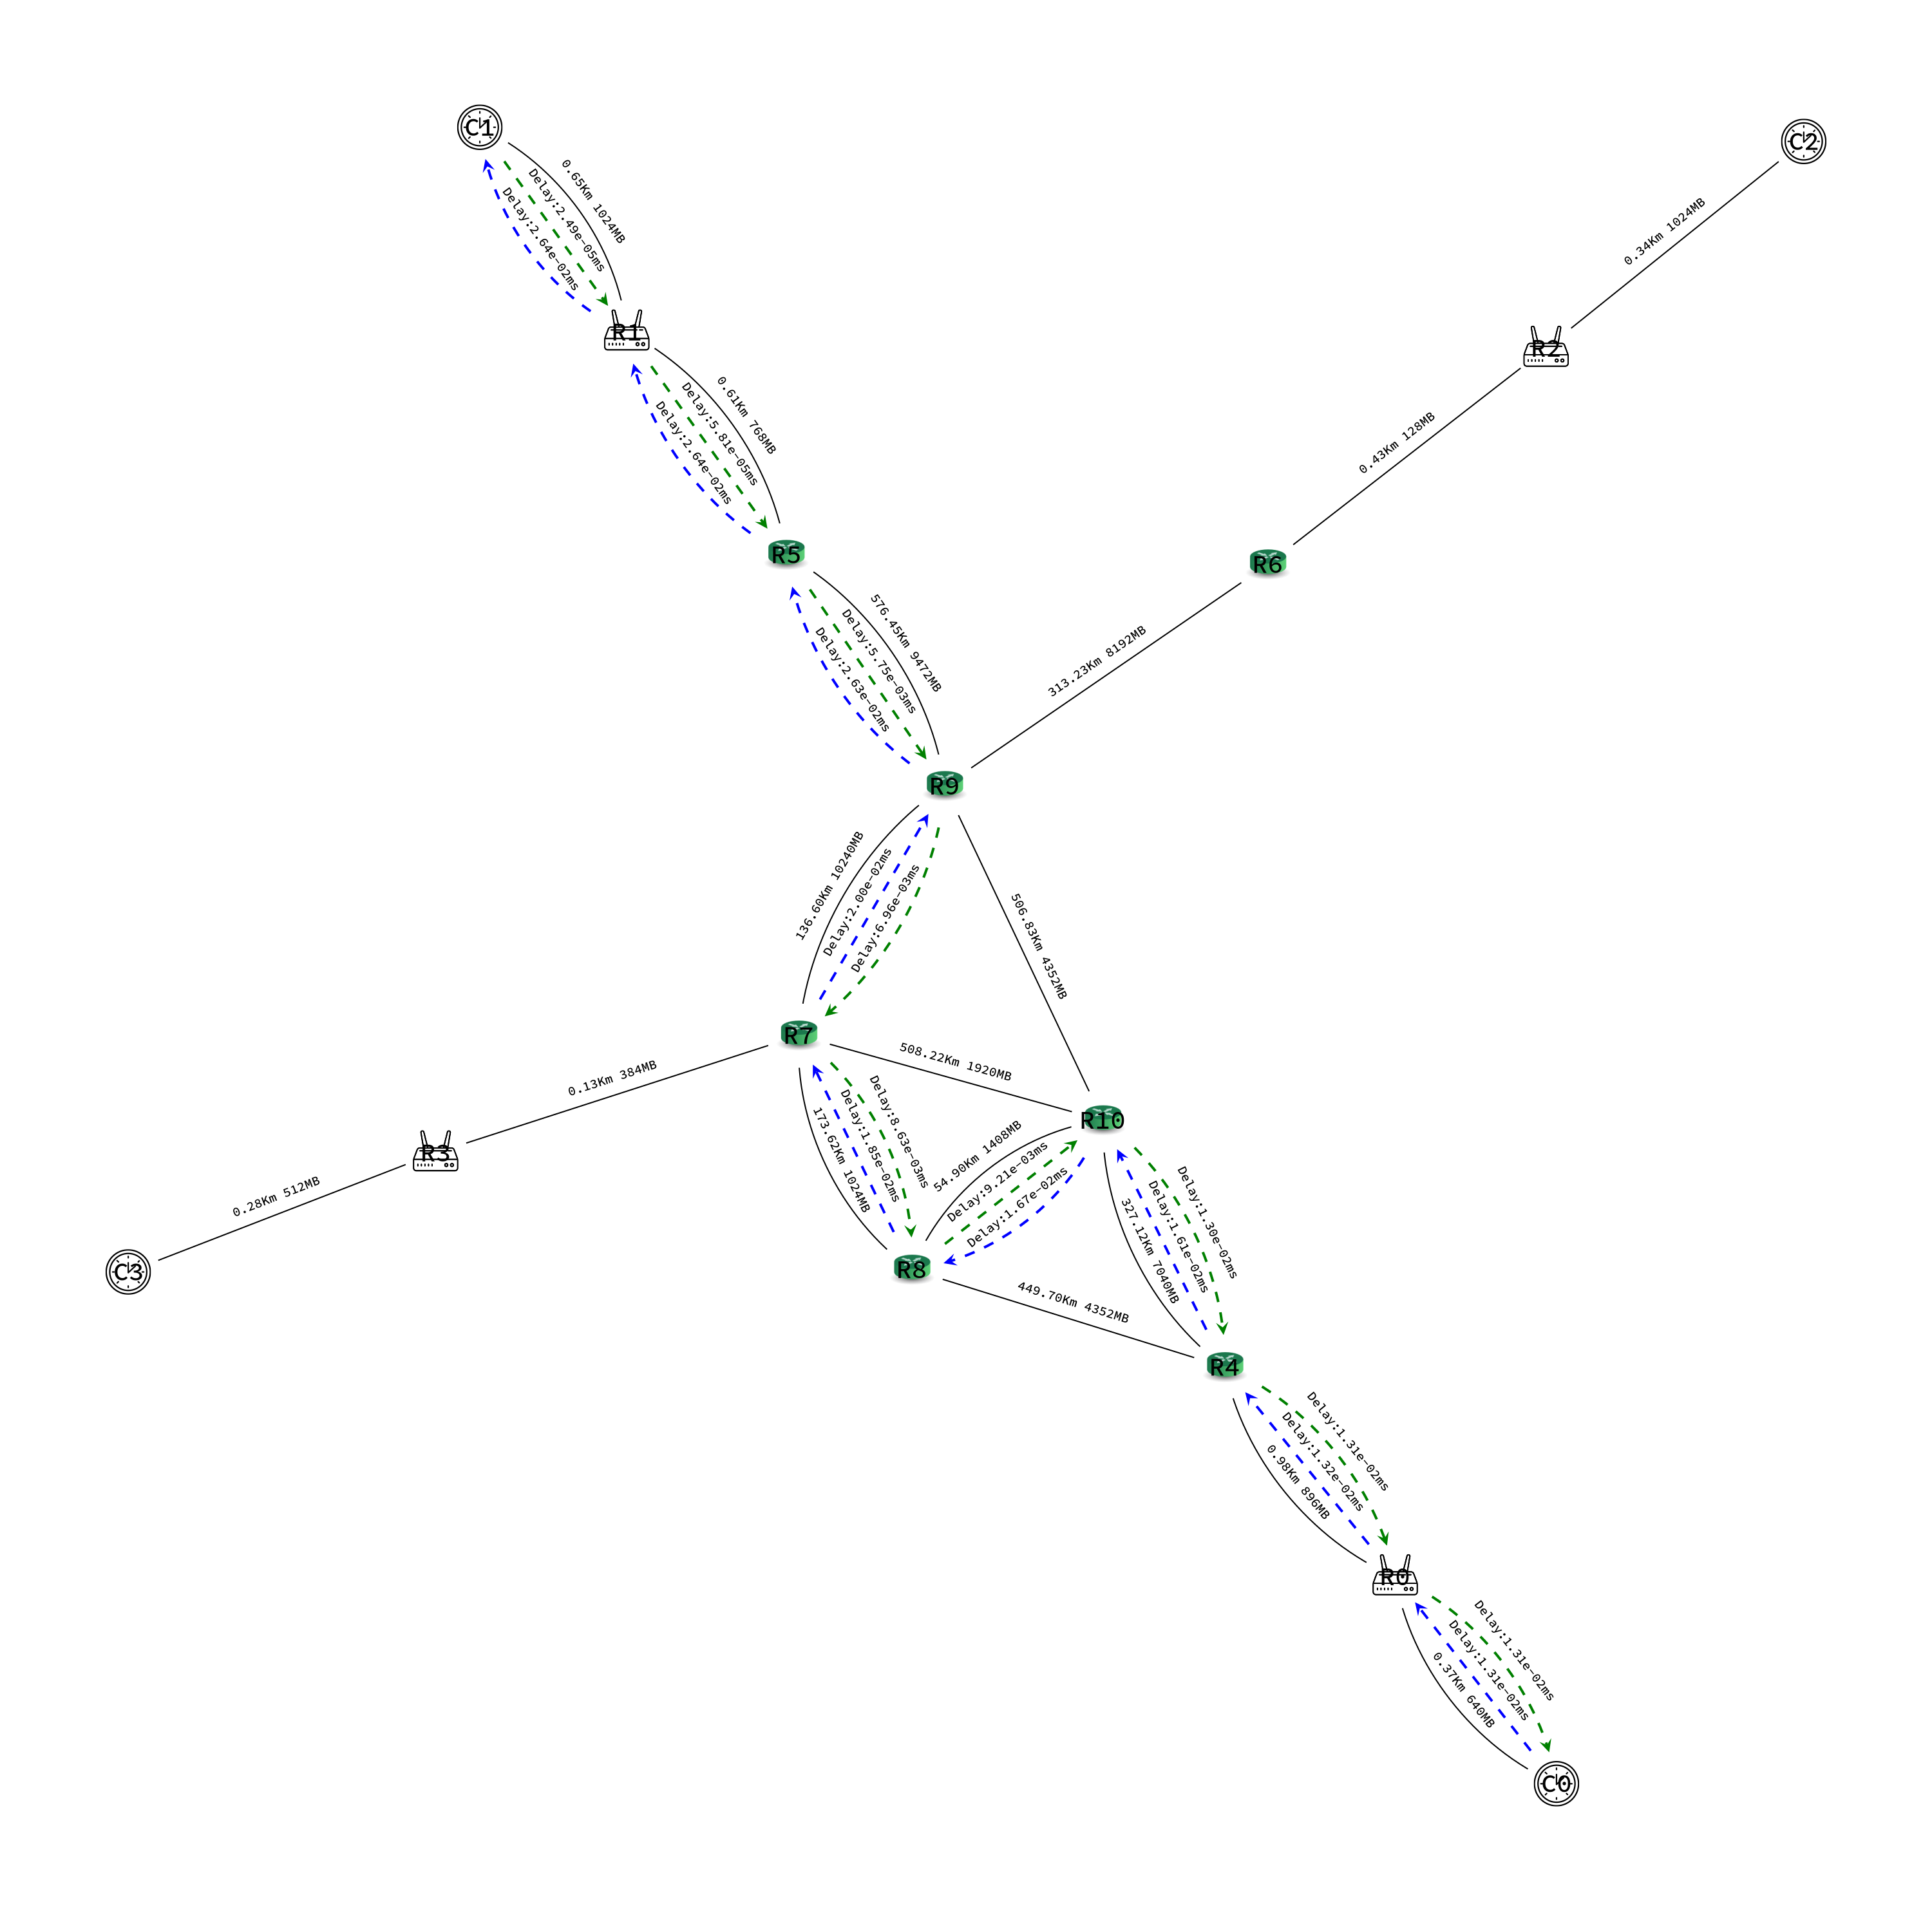

In [11]:
print(f'Total Package Size = {package_size}Byte')
print(f'Total Delay:{total_delay:.2e}ms')
a = graph_draw(g
               ,pos=g_pos
               ,eorder=g_eorder
               ,vertex_text=g_v_label
               ,output_size=(1500,1500)
               ,vertex_surface=g_sfcs
               ,vertex_size=g_v_size
               ,vertex_color=g_v_color
               ,vertex_fill_color=g_v_fill_color
               ,vertex_halo=g_v_halo
               ,vertex_font_size=g_v_font_size
               ,vertex_halo_size=g_v_halo_size
               ,vertex_text_offset=g_v_text_offset
               ,vertex_text_position=g_v_text_position
               ,vertex_pen_width=g_v_pen_width
               ,edge_end_marker=g_e_end_mark
               ,edge_pen_width=g_e_pen_width
               ,edge_marker_size=g_e_marker_size
               ,edge_text=g_e_text
               ,edge_text_parallel=g_e_text_parallel
               ,edge_font_size=g_e_text_font_size
               ,edge_color=g_e_color
               ,edge_text_distance=g_e_text_distance
               ,edge_dash_style = g_e_dash_style
               ,output=config.get('config', 'output') if config.get('config', 'output') != "" else None
              )